In [1]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import matplotlib.pyplot as plt
import glob
import os
import re
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy.sparse import coo_matrix, hstack, vstack
from collections import defaultdict

from ALLCools.clustering import tsne, binarize_matrix
from ALLCools.plot import *
from ALLCools.integration import SeuratIntegration

import scanpy as sc
import anndata
from harmonypy import run_harmony

In [2]:
mC_adata = anndata.read_h5ad("/gale/netapp/DoD/wenliang/projects/05.COVID/20.cluterWithCtrl/01.clusering/COVID.Ctrl.All.TSNE.Annotation.mcad")

In [3]:
bin_df = pd.read_csv("/gale/netapp/DoD/wenliang/projects/05.COVID/02.clustering/00.data/5kb_bin.bed",
                     sep="\t", names=['chrom', 'start', 'end','binID'])
transfer_id = dict()
for i, row in bin_df.iterrows():
    atac_id = f'{row.chrom}:{row.start}-{row.end}'
    transfer_id[atac_id] = row.binID

In [4]:
h5ad_files = glob.glob("*.h5ad")
h5ad_files = [x for x in h5ad_files if 'lsi' not in x and 'final' not in x]

In [5]:
adata_list = list()
for h5file in h5ad_files:
    atac_adata = anndata.read_h5ad(h5file)
    atac_adata.var_names = [transfer_id[x] if x in transfer_id else x for x in atac_adata.var_names]
    use_var = mC_adata.var_names.intersection(atac_adata.var_names)
    mC_adata._inplace_subset_var(use_var)
    atac_adata._inplace_subset_var(use_var)
    binarize_matrix(atac_adata, cutoff=1)
    adata_list.append(atac_adata)

In [14]:
atac_adata.obs

,tsse,n_fragment,frac_dup,frac_mito,annotation,sample_cluster,group_cluster
Cell,,,,,,,
AAACGAAAGAAGAGTG-1,12.409812,1511,0.212200,0.0,Tc-Mem,ATAC_66D7_fragments_Tc-Mem,C19_mild_Tc-Mem
AAACGAAAGAAGCCGT-1,9.681228,1828,0.276040,0.0,Tc-Mem,ATAC_66D7_fragments_Tc-Mem,C19_mild_Tc-Mem
AAACGAAAGACAGCTG-1,8.869180,2010,0.197925,0.0,Th-Mem,ATAC_66D7_fragments_Th-Mem,C19_mild_Th-Mem
AAACGAAAGACTAATG-1,11.570248,1259,0.235115,0.0,Tc-Mem,ATAC_66D7_fragments_Tc-Mem,C19_mild_Tc-Mem
AAACGAAAGAGGCGGA-1,10.909091,1189,0.222368,0.0,Th-Mem,ATAC_66D7_fragments_Th-Mem,C19_mild_Th-Mem
...,...,...,...,...,...,...,...
TTTGTGTTCTATCCTA-1,14.949495,1143,0.275206,0.0,NK-cell1,ATAC_66D7_fragments_NK-cell1,C19_mild_NK-cell1
TTTGTGTTCTCATCCG-1,9.839572,1907,0.292918,0.0,Tc-Mem,ATAC_66D7_fragments_Tc-Mem,C19_mild_Tc-Mem
TTTGTGTTCTCCTTGG-1,12.500000,2032,0.275321,0.0,Tc-Mem,ATAC_66D7_fragments_Tc-Mem,C19_mild_Tc-Mem


In [6]:
atac_data = anndata.AnnData(vstack([x.X for x in adata_list]), obs=pd.concat([x.obs for x in adata_list]), var=adata_list[0].var)

/tmp/ipykernel_601376/1985924877.py:1: FutureWarning: X.dtype being converted to np.float32 from int8. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac_data = anndata.AnnData(vstack([x.X for x in adata_list]), obs=pd.concat([x.obs for x in adata_list]), var=adata_list[0].var)
/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
cond_cell_mC = dict()
for (cond, cell), group_df in mC_adata.obs.groupby(['condition', 'annotation']):
    group_adata = mC_adata[(mC_adata.obs['condition']==cond) & (mC_adata.obs['annotation']==cell)]
    group_adata_df = group_adata.to_df()
    cond_cell_mC[f'{cond}_{cell}'] = group_adata_df.mean()
cond_cell_mC_df = pd.DataFrame.from_dict(cond_cell_mC, orient='index')

In [11]:
metadata = pd.read_csv("All_sample_finalATAC.metadata.csv", sep="\t")
id2group_cluster = dict(zip(["_".join(x.split("_")[-2:]) for x in metadata['cell']], metadata['group_cluster']))

In [17]:
atac_data.obs.index = atac_data.obs.apply(lambda row: "_".join(row.sample_cluster.split("_")[:-1]) + "_" + row.name, axis=1)

In [42]:
group_activity = dict()
for group, group_df in atac_data.obs.groupby('group_cluster'):
    group_adata = atac_data[atac_data.obs['group_cluster']==group]
#     group_adata_df = group_adata.to_df()
    group_activity[group] = np.asarray(group_adata.X.mean(axis=0))[0,:]
group_activity_df = pd.DataFrame.from_dict(group_activity, orient='index', columns=atac_data.var.index)

In [43]:
cond_cell_mC_df.index = [f'mC_{"_".join(x.split("_")[-2:])}' for x in cond_cell_mC_df.index]
group_activity_df.index = [f'ATAC_{"_".join(x.split("_")[-2:])}' for x in group_activity_df.index]

merge_5kb_mC_ATAC = pd.concat([cond_cell_mC_df, group_activity_df])
corr_df = merge_5kb_mC_ATAC.T.corr()

In [44]:
merge_5kb_mC_ATAC

,bin160,bin161,bin162,bin163,bin164,bin165,bin167,bin168,bin169,bin170,...,bin574992,bin574993,bin574994,bin574995,bin574996,bin574997,bin574999,bin575000,bin575001,bin575002
mC_C_B-Mem,0.000000,0.029316,0.009772,0.016287,0.042345,0.000000,0.000000,0.022801,0.013029,0.000000,...,0.091205,0.042345,0.055375,0.026059,0.026059,0.026059,0.013029,0.000000,0.003257,0.013029
mC_C_B-Naive,0.000000,0.003752,0.015009,0.007505,0.020638,0.001876,0.000000,0.056285,0.015009,0.001876,...,0.001876,0.001876,0.000000,0.001876,0.003752,0.026266,0.000000,0.000000,0.000000,0.052533
mC_C_B-cell,0.000000,0.000000,0.013953,0.004651,0.032558,0.000000,0.000000,0.032558,0.032558,0.000000,...,0.018605,0.023256,0.009302,0.000000,0.013953,0.013953,0.000000,0.004651,0.009302,0.055814
mC_C_Monocyte,0.003759,0.001880,0.005639,0.000000,0.080827,0.000000,0.000000,0.026316,0.011278,0.001880,...,0.003759,0.020677,0.001880,0.003759,0.003759,0.018797,0.003759,0.003759,0.000000,0.073308
mC_C_Monocyte1,0.008143,0.000000,0.008143,0.004886,0.087948,0.003257,0.001629,0.045603,0.001629,0.001629,...,0.001629,0.024430,0.000000,0.003257,0.004886,0.017915,0.001629,0.000000,0.001629,0.102606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATAC_sev_Other-cell,0.000403,0.001614,0.001614,0.000807,0.010488,0.009681,0.004841,0.004841,0.006051,0.002824,...,0.008875,0.006858,0.009278,0.002824,0.000807,0.000403,0.000807,0.000807,0.003227,0.002017
ATAC_sev_Tc-Mem,0.000448,0.001508,0.000408,0.000693,0.004851,0.009498,0.002853,0.001712,0.004280,0.003424,...,0.006970,0.007378,0.004851,0.003465,0.002935,0.000734,0.001019,0.000856,0.001508,0.001875
ATAC_sev_Tc-Naive,0.000748,0.001497,0.000842,0.000468,0.005987,0.009730,0.002807,0.002245,0.007017,0.003555,...,0.008607,0.008981,0.005707,0.002432,0.003462,0.000936,0.000468,0.000281,0.001871,0.001778
ATAC_sev_Th-Mem,0.000549,0.000713,0.000494,0.000878,0.004665,0.009275,0.003403,0.002360,0.004336,0.003677,...,0.006860,0.007025,0.006202,0.003622,0.002525,0.001537,0.000878,0.000823,0.001317,0.002086


In [45]:
select_index = [x for x in corr_df.index if x.startswith('mC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]
select_columns = [x for x in corr_df.columns if x.startswith('ATAC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]

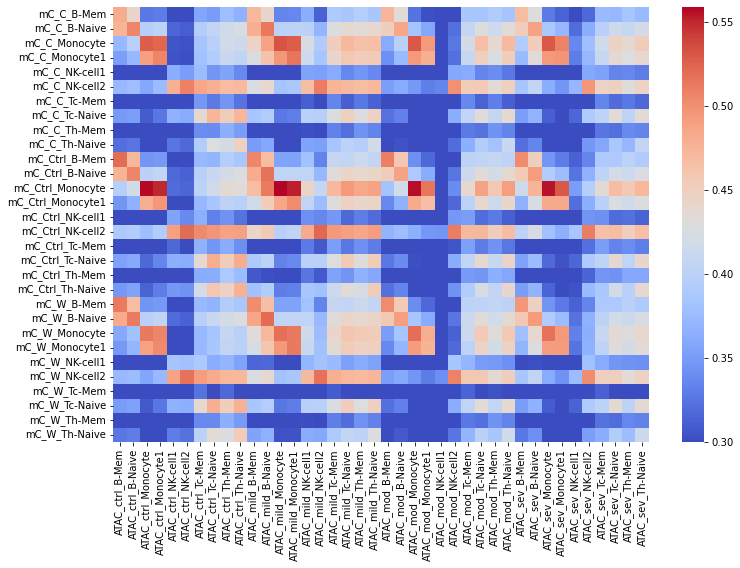

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(corr_df.loc[select_index, select_columns], cmap='coolwarm', vmin=0.3)
plt.savefig("mC_ATAC_corr.pdf")

# Read 5kb bin MCDS

In [20]:
from ALLCools.mcds import MCDS

In [21]:
mcds = MCDS.open("/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/MCDS/HIV_bulk", var_dim='chrom5k')

In [37]:
mcds.add_mc_rate(var_dim='chrom5k', normalize_per_cell=False, clip_norm_value=10)
chrom5k_mC = mcds['chrom5k_da_frac'].squeeze().to_pandas()

/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [111]:
chrom5k_mC.index = [f'mC_{"_".join(x.split("_")[-2:])}' for x in chrom5k_mC.index]
group_activity_df.index = [f'ATAC_{"_".join(x.split("_")[-2:])}' for x in group_activity_df.index]

merge_5kb_mC_ATAC = pd.concat([chrom5k_mC, group_activity_df])
corr_df = merge_5kb_mC_ATAC[target.index].T.corr(method='spearman')

In [112]:
select_index = [x for x in corr_df.index if x.startswith('mC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]
select_columns = [x for x in corr_df.columns if x.startswith('ATAC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]

In [125]:
mc_target = merge_5kb_mC_ATAC.loc[[x for x in merge_5kb_mC_ATAC.index if x.startswith('mC')],target.index]
atac_target = merge_5kb_mC_ATAC.loc[[x for x in merge_5kb_mC_ATAC.index if x.startswith('ATAC')],target.index]

<AxesSubplot:>

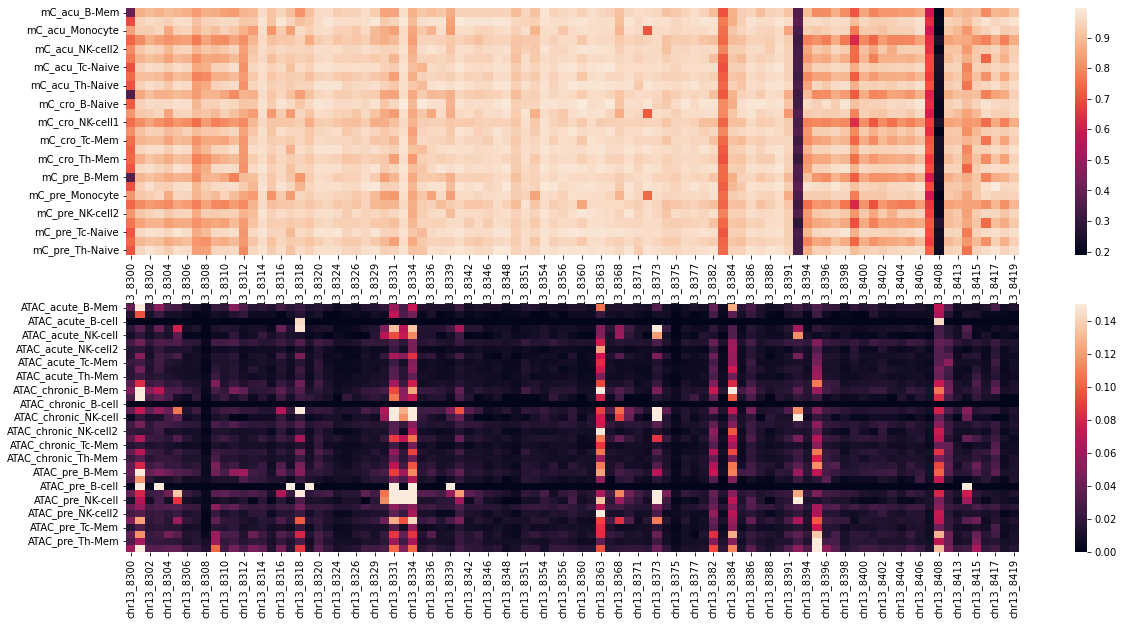

In [126]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.heatmap(mc_target, ax=ax[0])
sns.heatmap(atac_target, ax=ax[1], vmax=0.15)

/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mC_acu_B-Mem', ylabel='ATAC_acute_B-Mem'>

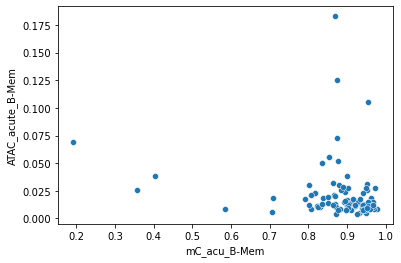

In [127]:
sns.scatterplot(mc_target.loc['mC_acu_B-Mem'], atac_target.loc['ATAC_acute_B-Mem'])

<AxesSubplot:>

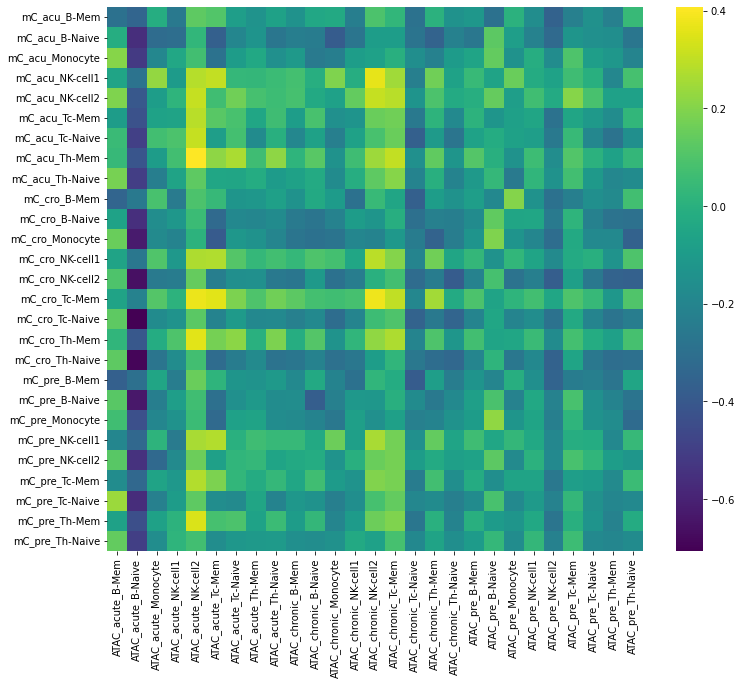

In [113]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(corr_df.loc[select_index, select_columns], cmap='viridis')

In [90]:
cond_cell_mC_df.index = [f'mC_{"_".join(x.split("_")[-2:])}' for x in cond_cell_mC_df.index]
chrom5k_mC.index = [f'ATAC_{"_".join(x.split("_")[-2:])}' for x in chrom5k_mC.index]

hypo_score_mC = pd.concat([cond_cell_mC_df, chrom5k_mC])
corr_df = hypo_score_mC.T.corr()

In [91]:
select_index = [x for x in corr_df.index if x.startswith('mC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]
select_columns = [x for x in corr_df.columns if x.startswith('ATAC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]

<AxesSubplot:>

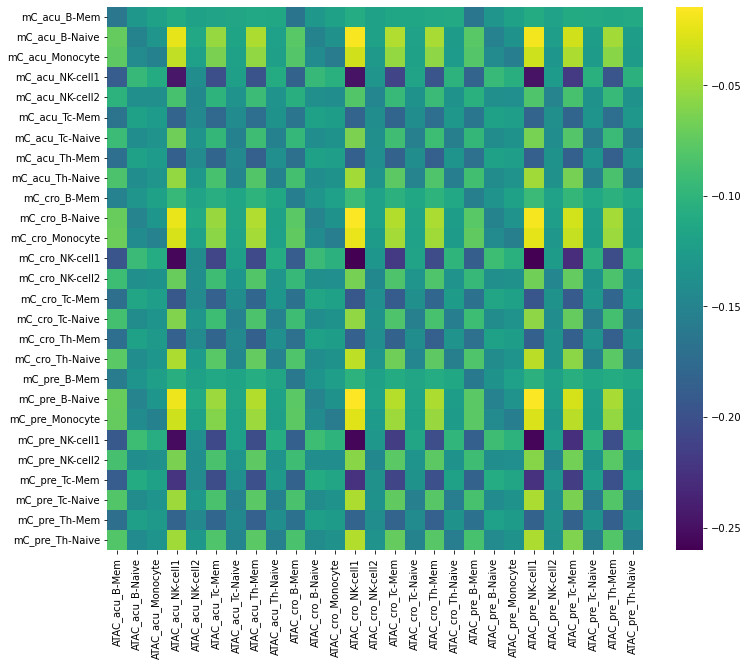

In [92]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(corr_df.loc[select_index, select_columns], cmap='viridis')